## Line plots
This notebook creates simple line plots to summarize the effect of three different link formation mechanisms on various network inequality metrics.
The link formation mechanisms are
- random `R`: Choose target node at random
- homophily `H`: Choose target node based on its group membership
- preferential attachment and homophily `PAH`: Choose target node based on its popularity
In addition, nodes may be limited by triadic closure, selecting only locally among their friends of friends or globally among all available nodes.

For each metric, we varying the link formation mechanisms per local and global scope, considering five combinations (`global, local`):
1. (R,R)
2. (H,R)
3. (H,H)
4. (PAH, R)
5. (PAH, PAH) 

The metrics are
- `gini`: Global degree inequality
- `ei`: Network segregation as ratio of out- and in-group links
- `stoch_dom`: Stochastic dominance in terms of degree of the minority group over the majority

As an input it takes aggregated statistics from a `.csv`-file.


### Imports and configuration

In [1]:
from typing import Optional
from itertools import product
import os

import matplotlib.pyplot as plt
import pandas as pd

from patch_workshop.constants import\
    LFM_RANDOM, LFM_HOMOPHILY, LFM_PAH,\
    TPL_LFM, MAP_LFM_SHORT

In- and output relative to this notebook file.

In [2]:
FILE_CSV = "../data/aggregate_statistics_vis.csv"
FOLDER_PLOTS = "../plots/"

Configuration and utility data structures to make the plotting easier.

In [3]:
COLORMAP_TC = plt.get_cmap("Oranges")
COLOR_NORM = lambda x: .15 + .7 * x

MAP_LFM_AX = {
    (LFM_RANDOM, LFM_RANDOM): (0, 0),
    (LFM_HOMOPHILY, LFM_RANDOM) : (0, 1),
    (LFM_HOMOPHILY, LFM_HOMOPHILY) : (1, 1),
    (LFM_PAH, LFM_RANDOM) : (0, 2),
    (LFM_PAH, LFM_PAH) : (1, 2),
}

plt.rcParams["font.size"] = 12


Some metadata

In [4]:
N = 5000 # Number of nodes
M = 2 # Number of new links per node
f = .3 # Fraction of the minority class

### Data
Read the data from the provided `.csv`-file.

In [5]:
data = pd.read_csv(FILE_CSV).set_index(["global", "local", "tc", "h", "r"]).sort_index()
data

gini        ei  stoch_dom
global    local     tc  h    r                                
homophily homophily 0.0 0.01 0   0.351292  0.961588   0.557948
                             1   0.351529  0.963189   0.564498
                             2   0.353489  0.961188   0.543760
                             3   0.350429  0.962589   0.567279
                             4   0.350666  0.965990   0.572946
...                                   ...       ...        ...
random    random    1.0 0.99 45  0.348779 -0.157547  -0.000516
                             46  0.348548 -0.151746  -0.001812
                             47  0.348190 -0.152146  -0.018869
                             48  0.347121 -0.158348   0.009573
                             49  0.343950 -0.157147   0.011973

[6250 rows x 3 columns]

Derive some constants (values for homophily, triadic closure and number of realizations) from the data table.

In [6]:
TC_VALS = data.index.get_level_values("tc").unique().sort_values()
H_VALS = data.index.get_level_values("h").unique().sort_values()
N_REAL = data.index.get_level_values("r").nunique()
print(f"homophily values: {H_VALS.values}")
print(f"triadic closure values: {TC_VALS.values}")
print(f"number of realizations: {N_REAL}")

homophily values: [0.01 0.2  0.5  0.8  0.99]
triadic closure values: [0.  0.2 0.5 0.8 1. ]
number of realizations: 50


### Plotting
Create, for each metric, a grid of five plots based on the combinations of local and global link formation mechanisms.

In [7]:
def plot_metric(metric: str, data: pd.DataFrame, vneutral: Optional[float] = None):
    assert metric in data.columns,\
        f"Could not find metric `{metric}` in data columns `{data.columns}`"

    # Create plot
    fig, a_ax = plt.subplots(
        nrows=2, ncols=3,
        sharex=True, sharey=True,
        figsize=(16* (2/3),9 * (2/3)))

    # Filter data by metric column
    data_metric = data[metric]

    # Go over all possible combinations of global and local LFM
    for lfm_global, lfm_local in product(TPL_LFM, repeat=2):
        if not (lfm_global, lfm_local) in data_metric.index:
            continue # Skip invalid combinations
        # Choose axis based on LFM combination
        ax = a_ax[MAP_LFM_AX[(lfm_global, lfm_local)]]

        # Filter data by LFM combination
        data_tc = data_metric.loc[(lfm_global, lfm_local)]

        # Create one line per triadic closure value
        for tc in TC_VALS:
            # Group by h and aggregate across realizations
            data_h_aggregates = data_tc\
                .loc[tc]\
                .groupby(axis="index", level="h")\
                .aggregate(["mean", "std"]) # Copmute mean and std

            # Plot mean with std error
            ax.errorbar(
                x=H_VALS,
                y=data_h_aggregates["mean"],
                yerr=data_h_aggregates["std"],
                color=COLORMAP_TC(COLOR_NORM(tc)),
                marker="s",
                label=f"{tc}" if lfm_global == LFM_RANDOM else None)
            if vneutral is not None:
                # Plot neutral metric line if provided
                ax.axhline(vneutral, color="black", linestyle="--")

            ax.set_title(f"{MAP_LFM_SHORT[lfm_global]}, {MAP_LFM_SHORT[lfm_local]}")

    # The bare minimum of making the plots look nice
    for ax in (a_ax[0,0], a_ax[1,1]):
        ax.set_ylabel(metric)
        ax.yaxis.set_tick_params(which='both', labelleft=True)

    for ax in a_ax[-1]:
        ax.set_xlabel("h")

    for ax in a_ax.flatten():
        ax.spines[["top", "right"]].set_visible(False)

    a_ax[0,0].set_xticks(H_VALS)
    a_ax[0,0].set_xlabel("h")
    a_ax[0,0].xaxis.set_tick_params(which='both', labelbottom=True)
    a_ax[1,0].set_visible(False)

    # Set legend and metadata in available space
    fig.legend(
        loc="lower left",
        bbox_to_anchor=(.15, .25),
        frameon=False, title="tc",
        ncols=2)
    fig.text(.07, .3, f"$N = {N}$\n$m = {M}$\n$f = {f}$")

    fig.tight_layout()
    file = os.path.join(FOLDER_PLOTS, f"{metric}.pdf")
    fig.savefig(file)
    print(f"Saving file to `{file}`.")

    return fig, a_ax

#### Plots per metric
Create plots for each metric.

Saving file to `../plots/gini.pdf`.


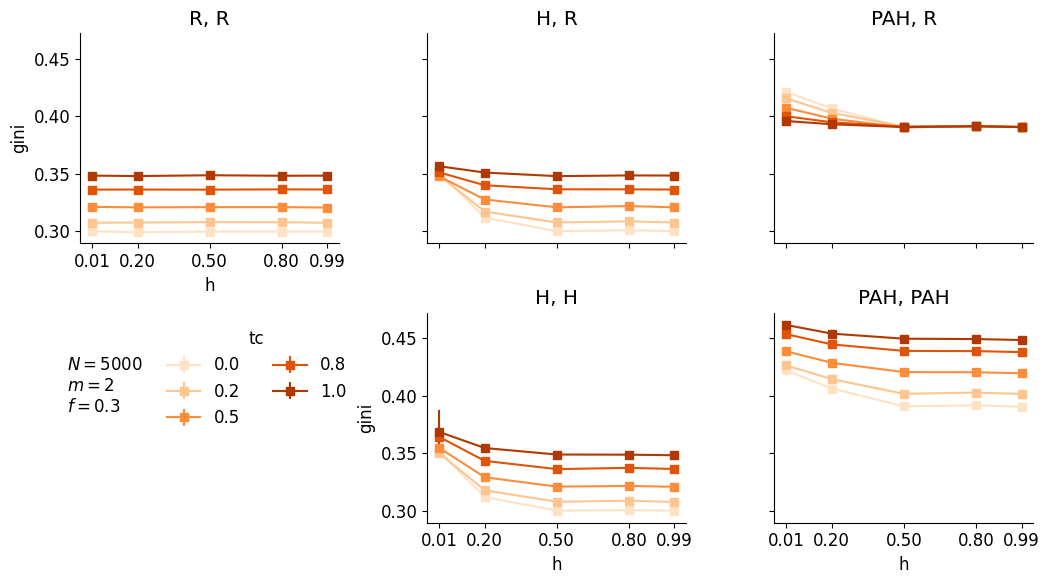

In [8]:
_ = plot_metric("gini", data)

Saving file to `../plots/ei.pdf`.


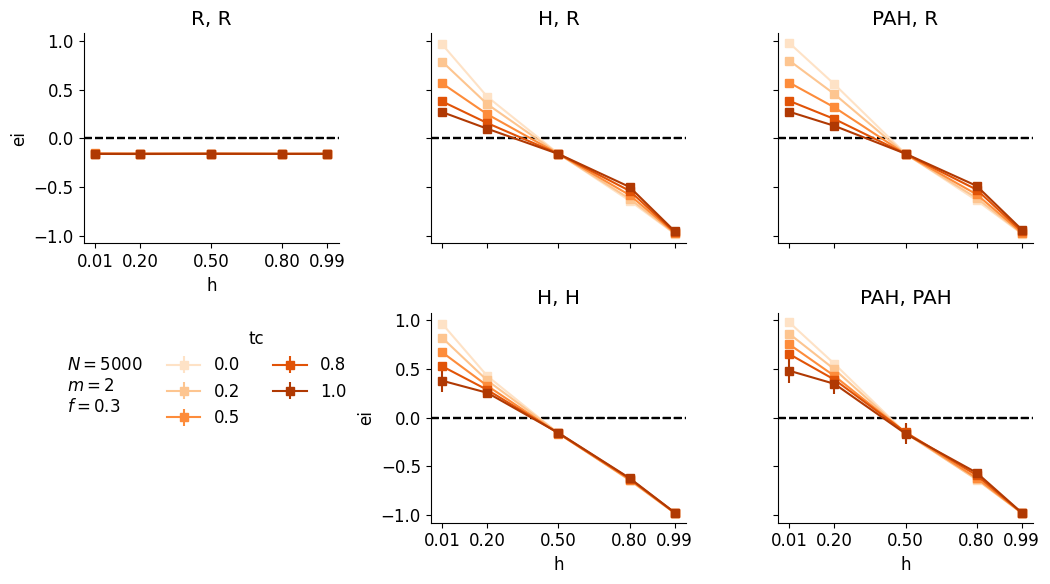

In [9]:
_ = plot_metric("ei", data, vneutral=0.)

Saving file to `../plots/stoch_dom.pdf`.


(<Figure size 1066.67x600 with 6 Axes>,
 array([[<Axes: title={'center': 'R, R'}, xlabel='h', ylabel='stoch_dom'>,
         <Axes: title={'center': 'H, R'}>,
         <Axes: title={'center': 'PAH, R'}>],
        [<Axes: xlabel='h'>,
         <Axes: title={'center': 'H, H'}, xlabel='h', ylabel='stoch_dom'>,
         <Axes: title={'center': 'PAH, PAH'}, xlabel='h'>]], dtype=object))

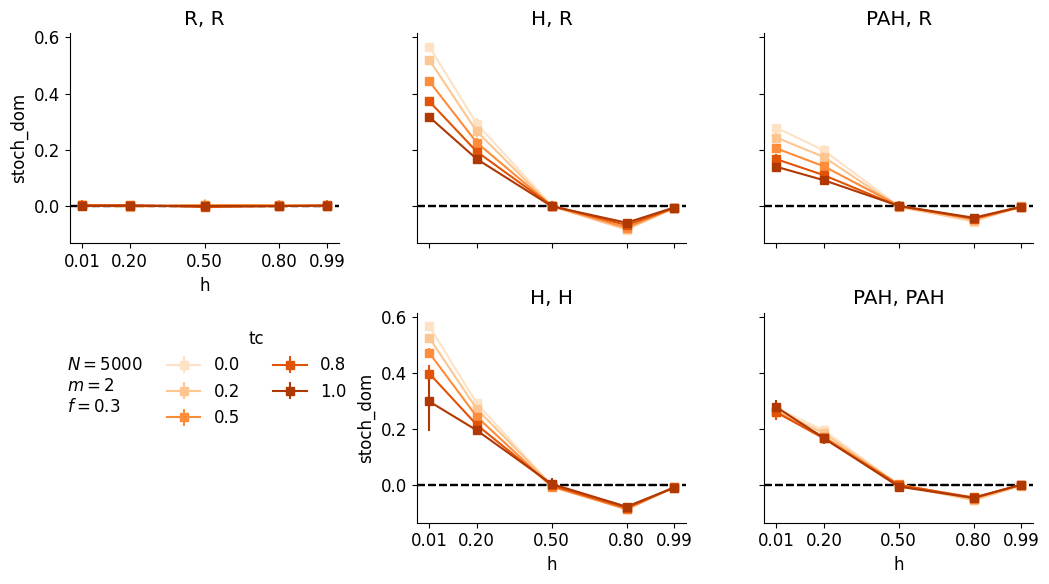

In [10]:
_ = plot_metric("stoch_dom", data, vneutral=0.)